In [55]:
import tensorflow as tf
import tensorflow_datasets as tfds
import datetime

## Downloading and preprocessing the data

In [56]:
BUFFER_SIZE = 70_000
BATCH_SIZE = 128
NUM_EPOCH =20

In [57]:
mnist_dataset, mnist_info = tfds.load(name="mnist", with_info=True, as_supervised=True)

split data into train and test sets

In [58]:
# Extracting the train and test datasets
mnist_train, mnist_test = mnist_dataset['train'], mnist_dataset['test']

create a function to scale the value[0,255] to value[0,1]

In [59]:
def scale(image, label):
    image =tf.cast(image, tf.float32) #to avoid problems with data types
    image /= 255.

    return image, label #need to include label in here because the map function below

apply above function to both mnist_train and mnist_test

In [60]:
train_and_validation_data = mnist_train.map(scale)
test_data = mnist_test.map(scale)

obtain the number training/validation samples

In [61]:
num_validation_samples =0.1 * mnist_info.splits["train"].num_examples
num_validation_samples = tf.cast(num_validation_samples, tf.int64)

same with test set

In [62]:
num_test_samples = mnist_info.splits["test"].num_examples
num_test_samples = tf.cast(num_test_samples, tf.int64)

Shuffle the dataset

In [63]:
train_and_validation_data = train_and_validation_data.shuffle(BUFFER_SIZE) #in this case MNIST dataset is relatively small we can shuffle in one go 
                                                                           #but for larger datasets we can set the BUFFER_SIZE to shuffle in batches
                                                                            

split our training set

In [64]:
train_data = train_and_validation_data.skip(num_validation_samples) #return everything except the first 10%
validation_data = train_and_validation_data.take(num_validation_samples) #return the first 10%

batch our dataset to improve performance

In [65]:
train_data = train_data.batch(batch_size=BATCH_SIZE) #larger batch size improve performance especially on GPU 
                                                     #but smaller batch size may provide better test accuracy and it's desirable to set it as power of 2
#validation and test sets don't need to be batched as we don't backward propagate on them however the model expects it to be batched to get the proper dimensions
validation_data = validation_data.batch(num_validation_samples)
test_data = test_data.batch(num_test_samples)

## Creating the model and training it

In [66]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(50, 5, activation="relu", input_shape=(28 , 28, 1)), #first layer with 50 kernel and size of 5 activation function of choice is relu
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)), #second layer, pool_size(2,2) is the default but we specified it for clarity
    tf.keras.layers.Conv2D(50, 3, activation="relu"), #input_shape removed as it's only needed in the first layer and smaller kernel size to accommandate smaller images
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Flatten(),  #this layer's purpose is to turn a multi-dimensional tensor into a a one-dimensional vector so we can perform classification in the next layer
    tf.keras.layers.Dense(10) #it's impossible to produce a numerically stable loss function for all models so we won't define activation function here
])

In [67]:
model.summary(line_length=75) #this is to check if our model initialised correctly 

Model: "sequential_2"
___________________________________________________________________________
 Layer (type)                    Output Shape                  Param #     
 conv2d_4 (Conv2D)               (None, 24, 24, 50)            1300        
                                                                           
 max_pooling2d_4 (MaxPooling2D)  (None, 12, 12, 50)            0           
                                                                           
 conv2d_5 (Conv2D)               (None, 10, 10, 50)            22550       
                                                                           
 max_pooling2d_5 (MaxPooling2D)  (None, 5, 5, 50)              0           
                                                                           
 flatten_2 (Flatten)             (None, 1250)                  0           
                                                                           
 dense_2 (Dense)                 (None, 10)                    125

loss function

In [68]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) #from_logits = True tells tf to use softmax activation

In [69]:
model.compile(optimizer="adam", loss=loss_fn, metrics=["accuracy"]) # this combines our model with loss function


Early stopping to prevent overfitting

In [70]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = "val_loss", #monitor validation loss during training
    mode = "auto",
    min_delta = 0,
    patience = 2,
    verbose = 0,
    restore_best_weights = True #this is set so that if validation loss increases for two epoch programme will stop
)

Setting up Tensorboard

In [71]:
log_dir = "log\\fit\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [72]:
model.fit(
    train_data,
    epochs = NUM_EPOCH,
    callbacks = [tensorboard_callback, early_stopping],  #it's possible to use more than one callbacks hence the []
                                                         #note early_stopping should be the last element in the list
                                                         #otherwise model may bug out
    validation_data = validation_data,
    verbose = 1 #2 means info will only be printed at end of each epoch
                #verbose = 2 seems to introduce an error in tensorboard
                #changed to 1 for this reason
)

Epoch 1/20
422/422 [==============================] - 3s 4ms/step - loss: 0.2716 - accuracy: 0.9233 - val_loss: 0.0782 - val_accuracy: 0.9760
Epoch 2/20
422/422 [==============================] - 2s 3ms/step - loss: 0.0707 - accuracy: 0.9785 - val_loss: 0.0509 - val_accuracy: 0.9850
Epoch 3/20
422/422 [==============================] - 2s 3ms/step - loss: 0.0525 - accuracy: 0.9844 - val_loss: 0.0415 - val_accuracy: 0.9872
Epoch 4/20
422/422 [==============================] - 2s 3ms/step - loss: 0.0429 - accuracy: 0.9867 - val_loss: 0.0371 - val_accuracy: 0.9888
Epoch 5/20
422/422 [==============================] - 2s 3ms/step - loss: 0.0366 - accuracy: 0.9887 - val_loss: 0.0341 - val_accuracy: 0.9907
Epoch 6/20
422/422 [==============================] - 2s 3ms/step - loss: 0.0308 - accuracy: 0.9902 - val_loss: 0.0229 - val_accuracy: 0.9928
Epoch 7/20
422/422 [==============================] - 2s 3ms/step - loss: 0.0278 - accuracy: 0.9915 - val_loss: 0.0248 - val_accuracy: 0.9922
Epoch 

As you can see the training stopped at 15th Epoch due to val_loss increase for 2 Epochs

# Testing our model

In [73]:
test_loss, test_accuracy = model.evaluate(test_data)

1/1 [==============================] - 0s 153ms/step - loss: 0.0328 - accuracy: 0.9907


In [74]:
print("Test loss: {0: .4f}. Test accuracy: {1: .2f}%".format(test_loss, test_accuracy*100))

Test loss:  0.0328. Test accuracy:  99.07%


Over 99% Accuracy!

## Plotting images and the results

In [75]:
import matplotlib.pyplot as plt
import numpy as np

In [76]:
#split the test data into 2 arrays, containing the images and the corresponding labels
for images, labels in test_data.take(1):
    images_test = images.numpy()
    labels_test = labels.numpy()

#reshape the image into 28x28 form, suitable for matplotlib (original dimension 28x28x1)
images_plot = np.reshape(images_test, (10000,28,28))

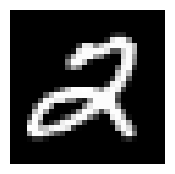

Label: 2


In [77]:
# The image to be displayed and tested
i = 1


# Plot the image
plt.figure(figsize=(2, 2))
plt.axis('off')
plt.imshow(images_plot[i-1], cmap="gray", aspect='auto')
plt.show()

# Print the correct label for the image
print("Label: {}".format(labels_test[i-1]))

1/1 [==============================] - 0s 38ms/step


<BarContainer object of 10 artists>

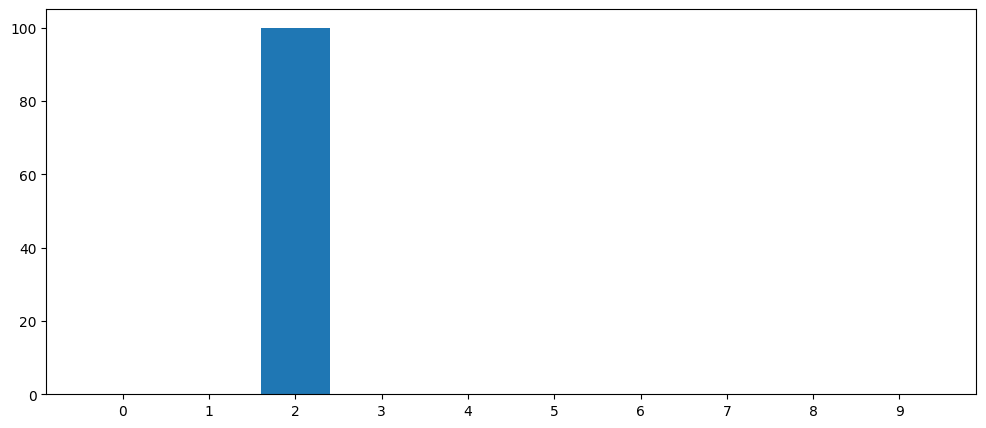

In [78]:
# Obtain the model's predictions (logits)
predictions = model.predict(images_test[i-1:i])

# Convert those predictions into probabilities (recall that we incorporated the softmaxt activation into the loss function)
probabilities = tf.nn.softmax(predictions).numpy()
# Convert the probabilities into percentages
probabilities = probabilities*100


# Create a bar chart to plot the probabilities for each class
plt.figure(figsize=(12,5))
plt.bar(x=[1,2,3,4,5,6,7,8,9,10], height=probabilities[0], tick_label=["0","1","2","3","4","5","6","7","8","9"])

Above graph shows our model have almost 100% confidence in the number 2

# Visualising in Tensorboard

In [79]:
%load_ext tensorboard
%tensorboard --logdir "logs/fit"


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 7748), started 3:04:17 ago. (Use '!kill 7748' to kill it.)

If tensorboard doesn't load try the following commands in cmd:

In [80]:
# taskkill /im tensorboard.exe /f
# del /q %TMP%\.tensorboard-info\*

#this will end existing tensorboard process and clean any temp data associated